In [1]:
#for data processing
import os
import json
import keras
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split

#for U-net model
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

> # Load Pre-processed Data

In [2]:
train_df = pd.read_csv('../input/edited-data/train_df.csv')
test_df = pd.read_csv('../input/edited-data/test_df.csv')

In [3]:
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()
train_df.head()

,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4,False
4,00031f466.jpg_1,NaN,00031f466.jpg,1,False


In [4]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
# print(mask_count_df.shape)
mask_count_df.head()

,ImageId,hasMask
10803,db4867ee8.jpg,3.0
11776,ef24da2ba.jpg,3.0
6284,7f30b9c64.jpg,2.0
9421,bf0c81db6.jpg,2.0
9615,c314f43f3.jpg,2.0


In [5]:
train_df.head()

,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4,False
4,00031f466.jpg_1,NaN,00031f466.jpg,1,False


# **submission data**

In [6]:
sub_df_origin = pd.read_csv('../input/severstal-steel-defect-detection/sample_submission.csv')
sub_df_origin.head()

,ImageId,EncodedPixels,ClassId
0,0000f269f.jpg,1 409600,0
1,000ccc2ac.jpg,1 409600,0
2,002451917.jpg,1 409600,0
3,003c5da97.jpg,1 409600,0
4,0042e163f.jpg,1 409600,0


In [7]:
sub_df = pd.DataFrame(columns=['ImageId_ClassId','EncodedPixels'])
for i in tqdm(range(len(sub_df_origin))):
    for j in range(4):
        tmp_se = pd.Series( [sub_df_origin['ImageId'][i]+'_{}'.format(j+1),None], index=sub_df.columns )
        sub_df = sub_df.append( tmp_se, ignore_index=True )
sub_df['ImageId'] = sub_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
sub_df.head()

100%|██████████| 5506/5506 [00:33<00:00, 165.73it/s]


,ImageId_ClassId,EncodedPixels,ImageId
0,0000f269f.jpg_1,None,0000f269f.jpg
1,0000f269f.jpg_2,None,0000f269f.jpg
2,0000f269f.jpg_3,None,0000f269f.jpg
3,0000f269f.jpg_4,None,0000f269f.jpg
4,000ccc2ac.jpg_1,None,000ccc2ac.jpg


In [8]:
test_df = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

In [9]:
test_df.head()

,ImageId
0,0000f269f.jpg
1,000ccc2ac.jpg
2,002451917.jpg
3,003c5da97.jpg
4,0042e163f.jpg


> # Utility Functions

## RLE Mask Encoding and Decoding
Source: [RLE Functions by Paulo Pinto](http://https://www.kaggle.com/code/paulorzp/rle-functions-run-lenght-encode-decode/script)

In [10]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(256,1600)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [11]:
def build_masks(rles, input_shape):
    depth = len(rles)
    height, width = input_shape
    masks = np.zeros((height, width, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, (width, height))
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

## Loss function

In [12]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# Data Generator

In [13]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='../input/severstal-steel-defect-detection/train_images',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

In [14]:
BATCH_SIZE = 16

train_idx, val_idx = train_test_split(
    mask_count_df.index, random_state=2019, test_size=0.15
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

# Model Architecture

In [15]:
def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
    
    return model

# Training

In [16]:
model = build_model((256, 1600, 1))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 1600, 8) 80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 1600, 8) 584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 800, 8)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [17]:
checkpoint = ModelCheckpoint(
    '60e-rUnet.h5', 
    monitor='val_dice_coef', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=1,
    epochs=60
)

Epoch 1/60
667/667 [==============================] - 545s 817ms/step - loss: 0.0536 - dice_coef: 0.0538 - val_loss: 0.0286 - val_dice_coef: 0.1322
Epoch 2/60
667/667 [==============================] - 485s 728ms/step - loss: 0.0270 - dice_coef: 0.2032 - val_loss: 0.0249 - val_dice_coef: 0.2820
Epoch 3/60
667/667 [==============================] - 487s 730ms/step - loss: 0.0241 - dice_coef: 0.2674 - val_loss: 0.0226 - val_dice_coef: 0.2834
Epoch 4/60
667/667 [==============================] - 486s 729ms/step - loss: 0.0228 - dice_coef: 0.2955 - val_loss: 0.0212 - val_dice_coef: 0.3388
Epoch 5/60
667/667 [==============================] - 489s 733ms/step - loss: 0.0219 - dice_coef: 0.3136 - val_loss: 0.0211 - val_dice_coef: 0.2970
Epoch 6/60
667/667 [==============================] - 488s 732ms/step - loss: 0.0210 - dice_coef: 0.3371 - val_loss: 0.0207 - val_dice_coef: 0.3354
Epoch 7/60
667/667 [==============================] - 487s 731ms/step - loss: 0.0200 - dice_coef: 0.3594 - val_l

# Evaluation & Submission

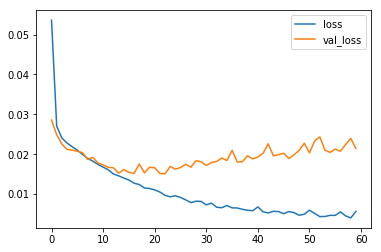

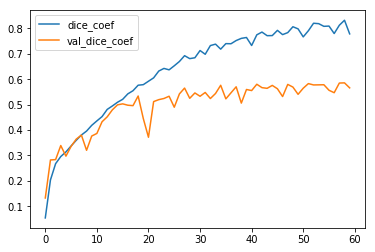

In [18]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

In [19]:
model.load_weights('60e-rUnet.h5')
pred_df = []

for i in range(0, test_df.shape[0], 500):
    batch_idx = list(
        range(i, min(test_df.shape[0], i + 500))
    )
    
    test_generator = DataGenerator(
        batch_idx,
        df=test_df,
        shuffle=False,
        mode='predict',
        base_path='../input/severstal-steel-defect-detection/test_images',
        target_df=sub_df,
        batch_size=1,
        n_classes=4
    )
    
    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )
    
    for j, b in tqdm(enumerate(batch_idx)):
        filename = test_df['ImageId'].iloc[b]
        image_df = sub_df[sub_df['ImageId'] == filename].copy()
        
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks)
        
        image_df['EncodedPixels'] = pred_rles
        pred_df.append(image_df)

500/500 [==============================] - 8s 17ms/step


500it [00:07, 64.48it/s]

  4/500 [..............................] - ETA: 9s 

500/500 [==============================] - 8s 17ms/step


500it [00:08, 61.82it/s]

  1/500 [..............................] - ETA: 12s

500/500 [==============================] - 8s 16ms/step


500it [00:08, 56.13it/s]

  1/500 [..............................] - ETA: 14s

500/500 [==============================] - 8s 16ms/step


500it [00:08, 59.72it/s]

  1/500 [..............................] - ETA: 11s

500/500 [==============================] - 8s 16ms/step


500it [00:08, 58.70it/s]

  5/500 [..............................] - ETA: 8s 

500/500 [==============================] - 8s 16ms/step


500it [00:08, 60.09it/s]

  5/500 [..............................] - ETA: 8s 

500/500 [==============================] - 8s 17ms/step


500it [00:08, 64.40it/s]

  5/500 [..............................] - ETA: 7s 

500/500 [==============================] - 8s 16ms/step


500it [00:08, 58.03it/s]


500/500 [==============================] - 8s 16ms/step


500it [00:08, 61.17it/s]

  1/500 [..............................] - ETA: 12s

500/500 [==============================] - 8s 16ms/step


500it [00:08, 56.23it/s]

  5/500 [..............................] - ETA: 7s 

500/500 [==============================] - 8s 16ms/step


500it [00:08, 61.07it/s]


6/6 [==============================] - 0s 18ms/step


6it [00:00, 59.26it/s]


In [20]:
pred_df = pd.concat(pred_df)
pred_df.drop(columns='ImageId', inplace=True)
print(pred_df.shape)
pred_df.head(100)

(22024, 2)


,ImageId_ClassId,EncodedPixels
0,0000f269f.jpg_1,
1,0000f269f.jpg_2,
2,0000f269f.jpg_3,145066 1 145068 1 145074 1 145529 1 145552 1 1...
3,0000f269f.jpg_4,
4,000ccc2ac.jpg_1,
5,000ccc2ac.jpg_2,
6,000ccc2ac.jpg_3,
7,000ccc2ac.jpg_4,
8,002451917.jpg_1,
9,002451917.jpg_2,


In [21]:
pred_df.to_csv('60e-rUnet-submission.csv', index=False)